# CS 6330
## Final Project
## Distinguish Between Two Walkers
### Robert Burkhardt
### Dan Olson
### Rich Lukas
### 2/14/23

### Load Libraries

In [139]:
from collections import defaultdict as dd
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from ModelAuto.Multicollinearity import handel_Multico_VIF
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from numpy import *
from numpy import linalg as LA
from patsy import dmatrices
from pylab import *
from scipy import signal
from scipy.sparse import csr_matrix, find
from scipy.stats import chisquare
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.cluster import rand_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import random
import scipy as sci
import scipy.stats as stats
import seaborn as sns
import sklearn
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import statistics 
import statsmodels.api as sm
import tensorflow as tf
import time
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import copy
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category
print("Libraries Loaded")

Libraries Loaded


## Create Data Frames

In [2]:
# !!! ONLY RUN THIS CELL ONCE
# RESTART NOTEBOOK IF RUN MORE THAN ONCE
notebook_path = os.path.abspath("")

In [130]:
#display(HTML("<script>$('div.cell.selected').children('div.output_wrapper').height(800);</script>"))
df_dso = pd.DataFrame(columns=['time','gFx','gFy','gFz','wx','wy','wz','Unnamed: 7','time_elapsed'])
df_rl = pd.DataFrame(columns=['time','gFx','gFy','gFz','wx','wy','wz','Unnamed: 7','time_elapsed'])
# df_sitting = pd.DataFrame(columns=['time','gFx','gFy','gFz','wx','wy','wz','Unnamed: 7','time_elapsed'])

data_path = os.path.join(notebook_path, "data\\dan-raw")
os.chdir(data_path)

#os.chdir('./Stairs')
# Get the list of all files and directories
for x in os.listdir():
    if x.endswith("walking normally.csv"):
        df = pd.read_csv(x)
        df['time_elapsed'] = round(df['time']*1e6)
        df['type'] = 'DO'
        df_dso = df_dso.append(df, ignore_index=True) 
df_dso = df_dso.drop('Unnamed: 7', axis=1) 
df_dso.reset_index(inplace = True,drop=True)
df_dso = df_dso.dropna(axis = 0, how ='any')
print(df_dso.shape)

data_path = os.path.join(notebook_path, "data\\richard-raw\\Logs_walking_straight")
os.chdir(data_path)

# Get the list of all files and directories
for x in os.listdir():
    if x.endswith("Hard.csv"):
        df = pd.read_csv(x)
        df['time_elapsed'] = round(df['time']*1e6)
        df['type'] = 'RL'
        df_rl = df_rl.append(df, ignore_index=True) 
df_rl = df_rl.drop('Unnamed: 7', axis=1) 
df_rl = df_rl.dropna(axis = 0, how ='any')
df_rl.reset_index(inplace = True,drop=True)
print(df_rl.shape)





(4671, 9)
(14030, 9)


df_combined[df_combined['type'] == "L"].info()

## Split data into 5 second blocks

In [131]:

dfs = []

# define the interval length (in seconds) that you want to split the data into
interval_length = 5000000

# RL data
df = df_rl

# set the time column as the dataframe's index
df = df.set_index('time_elapsed')

# calculate the start and end times of each interval
start_times = np.arange(df.index.min(), df.index.max(), interval_length)

# split the original dataframe into a list of dataframes each 5 seconds long
for start in start_times:
    dfs.append(df.loc[(df.index >= start) & (df.index < start + interval_length)])


#DSO data
df = df_dso

# set the time column as the dataframe's index
df = df.set_index('time_elapsed')

# calculate the start and end times of each interval
start_times = np.arange(df.index.min(), df.index.max(), interval_length)

# split the original dataframe into a list of dataframes each 5 seconds long
for start in start_times:
    dfs.append(df.loc[(df.index >= start) & (df.index < start + interval_length)])



In [132]:
for i in range(len(dfs)):
    print(len(dfs[i]))

2273
2269
2268
2269
2269
2268
90
0
0
0
0
0
0
0
0
0
0
0
324
215
221
222
221
315
293
221
221
221
221
221
221
221
221
222
221
221
221
221
221
89


In [133]:
print(dfs[1].head())
print(dfs[1].tail())
print(len(dfs))

                  time     gFx     gFy     gFz      wx     wy     wz type
time_elapsed                                                             
5019879.0     5.019879 -0.0782 -1.0927  0.8890  0.4928  2.843  0.326   RL
5022249.0     5.022249 -0.0430 -1.1294  0.8821  0.4928  2.843  0.326   RL
5024807.0     5.024807 -0.0066 -1.1592  0.8616  0.4928  2.843  0.326   RL
5027084.0     5.027084  0.0278 -1.1807  0.8377  0.4928  2.843  0.326   RL
5029389.0     5.029389  0.0613 -1.1975  0.8032  0.4928  2.843  0.326   RL
                   time     gFx     gFy     gFz      wx      wy      wz type
time_elapsed                                                                
10007352.0    10.007352 -0.2604 -0.9657 -0.5391  0.9908 -1.7101 -0.1746   RL
10009753.0    10.009753 -0.3623 -1.0466 -0.8181  0.9908 -1.7101 -0.1746   RL
10012087.0    10.012087 -0.4607 -1.1396 -1.1506  0.9908 -1.7101 -0.1746   RL
10014500.0    10.014500 -0.5594 -1.2474 -1.5139  0.9908 -1.7101 -0.1746   RL
10016755.0    10.016

## Clean Data

In [140]:
# Delete blocks that are empty or too small.  At 100hz data, 5 seconds = 500 rows
dfs_clean = copy.deepcopy(dfs)

dfs_clean = [block for block in dfs_clean if len(block) >= 200]

for i in reversed(range(len(dfs_clean))):
    dfs_clean[i].index = pd.Timestamp(datetime.date(1900,1,1)) + pd.TimedeltaIndex(dfs_clean[i].index, unit='us')
    dfs_clean[i].index = pd.to_datetime(dfs_clean[i].index)                    # Resample data
    dfs_clean[i] = dfs_clean[i].resample('10ms').agg(dict(type='first',gFx='mean',gFy='mean',gFz='mean',wx='mean',wy='mean',wz='mean'))                        # average values when downsampling
    dfs_clean[i] = dfs_clean[i].ffill()                                        # Fill forward when upsampling

# for i in reversed(del_list):
#     del dfs[i]
dfs_clean = [block for block in dfs_clean if len(block) >= 200]   

for i in range(len(dfs_clean)):
    print(len(dfs_clean[i]))

print(dfs_clean[1].head())
print(dfs_clean[1].tail())

501
501
501
500
501
501
499
497
501
499
498
500
499
498
498
499
499
499
498
498
501
498
499
499
499
498
                        type       gFx       gFy       gFz       wx       wy  \
time_elapsed                                                                   
1900-01-01 00:00:05.010   RL -0.078200 -1.092700  0.889000  0.49280  2.84300   
1900-01-01 00:00:05.020   RL  0.009875 -1.166700  0.846150  0.49280  2.84300   
1900-01-01 00:00:05.030   RL  0.042140 -1.233540  0.715580  1.97282  2.10614   
1900-01-01 00:00:05.040   RL -0.065920 -1.318660  0.567940  2.95950  1.61490   
1900-01-01 00:00:05.050   RL -0.133725 -1.386475  0.468025  2.95950  1.61490   

                              wz  
time_elapsed                      
1900-01-01 00:00:05.010  0.32600  
1900-01-01 00:00:05.020  0.32600  
1900-01-01 00:00:05.030  0.51416  
1900-01-01 00:00:05.040  0.63960  
1900-01-01 00:00:05.050  0.63960  
                        type      gFx       gFy       gFz       wx       wy  \
time_elapse

In [141]:
for x in range(len(dfs_clean)):
    dfs_clean[x].reset_index(inplace=True,drop=True)

print(dfs_clean)
print("DataFrames Created")

[    type       gFx       gFy       gFz        wx        wy        wz
0     RL -0.200417  0.249417  1.142833  0.000000  0.000000  0.000000
1     RL -0.219600  0.261000  0.981680  0.000000  0.000000  0.000000
2     RL -0.199650  0.301825  0.843425  0.000000  0.000000  0.000000
3     RL -0.181560  0.319360  0.772700  0.000000  0.000000  0.000000
4     RL -0.158850  0.301900  0.756150  0.000000  0.000000  0.000000
..   ...       ...       ...       ...       ...       ...       ...
496   RL -0.390514 -0.102186  0.423786  0.441257  2.142071  0.240829
497   RL -0.463000 -0.336525  0.649900  0.492800  2.843000  0.326000
498   RL -0.408050 -0.647875  0.852400  0.492800  2.843000  0.326000
499   RL -0.273375 -0.843075  0.852000  0.492800  2.843000  0.326000
500   RL -0.144250 -1.000650  0.865475  0.492800  2.843000  0.326000

[501 rows x 7 columns],     type       gFx       gFy       gFz       wx       wy       wz
0     RL -0.078200 -1.092700  0.889000  0.49280  2.84300  0.32600
1     RL  0.00

## Feature Creation

In [151]:
df_features = pd.DataFrame()
type_list = []
for i in range(len(dfs_clean)):
    type_list.append(dfs_clean[i]['type'][0])
df_features['type'] = type_list

def get_first_harmonic(signal):
    # create a sample input signal
    fs = 100  # sample rate
    t = np.arange(0, 1, 1/fs)  # time vector
    f1 = 100  # frequency of the signal

    # compute the FFT of the signal
    fft_signal = np.fft.fft(signal)

    # compute the frequency bins corresponding to each FFT coefficient
    freqs = np.fft.fftfreq(len(signal)) * fs

    # plot the magnitude spectrum
    # plt.figure()
    # plt.plot(freqs, np.abs(fft_signal))
    # plt.xlim(-10,10)
    # plt.xlabel('Frequency (Hz)')
    # plt.ylabel('Magnitude')
    # plt.title('Magnitude Spectrum')

    # identify the harmonics by finding the peaks in the spectrum
    peaks, _ = sci.signal.find_peaks(np.abs(fft_signal), height=(np.abs(fft_signal).max()/2))
    harmonics = freqs[peaks]
    # display the identified harmonics
    # print(f'The identified harmonics are: {harmonics}')

    return harmonics[0]

harmonic_list = []
for i in range(len(dfs_clean)):
    harmonic_list.append(get_first_harmonic(dfs_clean[i].wx))
df_features['FFT_H1'] = harmonic_list


The identified harmonics are: [ 0.99800399 -0.99800399]
The identified harmonics are: [ 0.99800399 -0.99800399]
The identified harmonics are: [ 0.99800399 -0.99800399]
The identified harmonics are: [ 1. -1.]
The identified harmonics are: [ 0.99800399 -0.99800399]
The identified harmonics are: [ 0.99800399 -0.99800399]
The identified harmonics are: [ 0.4008016   1.00200401  1.40280561 -1.40280561 -1.00200401 -0.4008016 ]
The identified harmonics are: [ 1.00603622  1.81086519 -1.81086519 -1.00603622]
The identified harmonics are: [ 0.99800399  1.99600798 -1.99600798 -0.99800399]
The identified harmonics are: [ 1.00200401  2.00400802 -2.00400802 -1.00200401]
The identified harmonics are: [ 1.00401606  1.80722892 -1.80722892 -1.00401606]
The identified harmonics are: [ 1.   1.8 -1.8 -1. ]
The identified harmonics are: [ 1.00200401  1.80360721 -1.80360721 -1.00200401]
The identified harmonics are: [ 1.00401606  1.80722892 -1.80722892 -1.00401606]
The identified harmonics are: [ 1.00401606  

In [150]:
print(df_features.head(50))

   type    FFT_H1
0    RL  0.998004
1    RL  0.998004
2    RL  0.998004
3    RL  1.000000
4    RL  0.998004
5    RL  0.998004
6    DO  0.400802
7    DO  1.006036
8    DO  0.998004
9    DO  1.002004
10   DO  1.004016
11   DO  1.000000
12   DO  1.002004
13   DO  1.004016
14   DO  1.004016
15   DO  1.002004
16   DO  1.002004
17   DO  1.002004
18   DO  0.803213
19   DO  0.602410
20   DO  0.798403
21   DO  0.803213
22   DO  0.801603
23   DO  0.801603
24   DO  0.801603
25   DO  0.803213


In [ ]:
def nextpow2(N):
    """ Function for finding the next power of 2 """
    n = 1
    while n < N: n *= 2
    return n

T = 1
nfft = len(dfs[1].gFx)
nfft2 = 2**nextpow2(nfft)
ff = fft(dfs[1].gFx, nfft2)
fff = (ff[: nfft2/2])
#xfft = np.ndarray Fs*[: (nfft2/2-1)/nfft2]
xf = np.linspace(0.0, 1.0/(2.0*T), nfft2/2)
plt.plot(xf, abs(fff))
plt.show()
idx = np.argmax(np.abs(fff))
print('Fundamental frequency :',  xf[idx])

ValueError: Maximum allowed dimension exceeded

In [ ]:
df_features = pd.DataFrame(columns=['type','gFx','gFy','gFz','wx','wy','wz','Unnamed: 7','time_elapsed'])

# for x in range(len(dfs)):

f = np.fft.fftfreq(dfs[1].gFx)
print(f)

ValueError: n should be an integer

## Create Stratified Test Train Split
### Scale Data with Zero mean and Unity Variance

In [ ]:
X = df_combined.copy(deep = True)
#X.pop('time')
#X.pop('time_elapsed')
y = X.pop('type')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
print('\nThe size of the X_train is ' + str(X_train.shape[0]) + ' by ' + str(X_train.shape[1]) )
print('\nThe size of the X_test is ' + str(X_test.shape[0]) + ' by ' + str(X_test.shape[1]) )
scaler = preprocessing.StandardScaler().fit(X_train)
#min_max_scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


The size of the X_train is 14025 by 6

The size of the X_test is 4676 by 6


## Run a Grid Search to Optimize the MLP Model Parameters
### This takes a long time to run

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=3000,early_stopping = True, random_state=1)

#parameter_space = {
#    'hidden_layer_sizes': [(100,), (125,)],
#    'activation': ['tanh', 'relu','logistic'],
#    'solver': ['sgd', 'adam','lbfgs'],
#    'alpha': [0.00001,0.0001],
#    'learning_rate': ['constant'],
#}
#'''
parameter_space = {
    'hidden_layer_sizes': [(100,), (125,)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['lbfgs'],
    'alpha': [0.0001],
    'learning_rate': ['constant'],
}
#'''

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
y_true, y_pred = y_test , clf.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (125,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.980 (+/-0.004) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.980 (+/-0.006) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (125,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.980 (+/-0.004) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.982 (+/-0.003) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (125,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.979 (+/-0.001) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.980 (+/-0.002) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (125,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
Results on the t

## Create a MLP Classifier Model
### NN = MLPClassifier(activation = "tanh", solver='lbfgs', alpha=0.0001, hidden_layer_sizes=(125, ), learning_rate = "constant", random_state=1,max_iter=200,early_stopping = True)

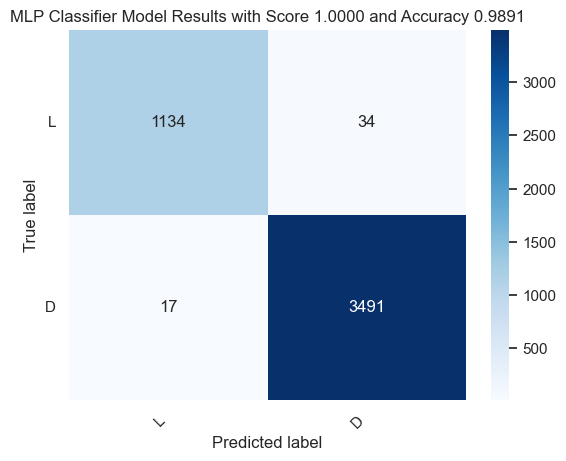

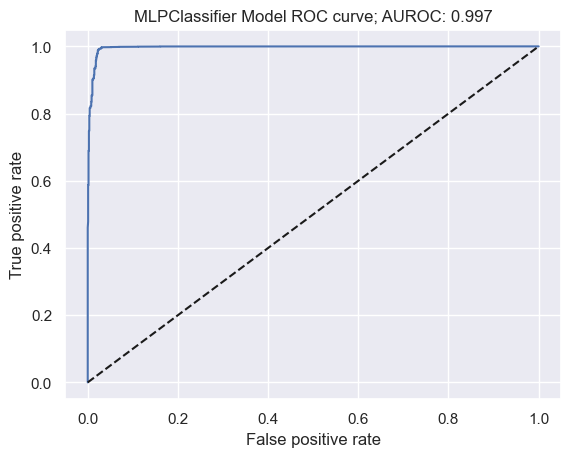

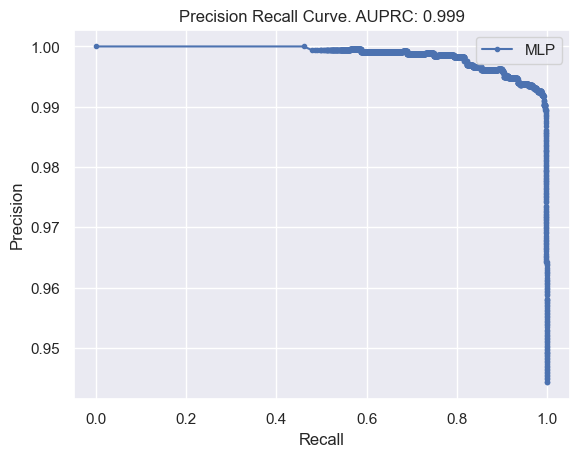

In [ ]:
from sklearn.neural_network import MLPClassifier
# {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (125,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
NN = MLPClassifier(activation = "tanh", solver='lbfgs', alpha=0.0001, hidden_layer_sizes=(125, ), learning_rate = "constant", random_state=1,max_iter=3000,early_stopping = True)
NN.fit(X_train, y_train)
yhat = NN.predict(X_test)
#print("Score: ", round(NN.score(X_test,yhat), 4))
#print("Accuracy: ", accuracy_score(y_test, yhat))
conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
classnames.reverse()
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

#print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(NN.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('MLP Classifier Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
plt.show() 

y_pred_proba = NN.predict_proba(np.array(X_test))[:,1]
y_test1 = y_test.replace('D',  0)
y_test1 = y_test1.replace('L',  1)
#y_test1 = y_test1.replace('C',  2)
fpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba)
sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
AUROC = np.round(roc_auc_score(y_test, y_pred_proba), 3)
plt.title(f'MLPClassifier Model ROC curve; AUROC: {AUROC}');
plt.show()


average_precision = average_precision_score(y_test1, y_pred_proba)
precision, recall, thresholds = precision_recall_curve(y_test1, y_pred_proba)
plt.plot(recall, precision, marker='.', label='MLP')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
average_precision = np.round(average_precision, 3)
plt.title(f'Precision Recall Curve. AUPRC: {average_precision}')
plt.show()